In [2]:
from detectors import GPDCAnomalies
from linear_pa import ScaleFreeDiGraph
import embeddings
import typing as tp

import networkx as nx
from sklearn.preprocessing import StandardScaler

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

We will try $(\alpha, \beta, \gamma) \in \{(0.15, 0.8, 0.05),(0.1, 0.5, 0.4), (0.6, 0.1, 0.3)\}$ and $\delta_{in}=\delta_{out}=1$.

Snapshots are fixed after exactly 100 steps of evolution.

The initial graph is obtained by 1000 steps of evolution.

In [4]:
alphas = [0.15, 0.1, 0.6]
betas = [0.8, 0.5, 0.1]
gammas = [0.05, 0.4, 0.3]

delta_in = delta_out = 1

In [5]:
init_steps = 1000
steps = 100

# Examples of anomaly detection

In [6]:
def visualise(data, anomalies, filename):
    plt.figure(figsize=(10, 6))
    
    plt.xlabel('PageRank', size=20)
    plt.ylabel('MLM', size=20)

    if anomalies is not None:
        normals = np.array(list(set(range(len(data))) - set(anomalies)))
        plt.scatter(x=data[normals, 0], y=data[normals, 1], alpha=0.2, color='black', label='normal')
        plt.scatter(x=data[anomalies, 0], y=data[anomalies, 1], s=64, linewidth=3, color='black', marker='x', label='abnormal')
    else:
        plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.2, color='black', label='normal')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

Let generate the initial graph by 1000 steps of evolution with parameters $(0.1, 0.5, 0.4)$ and we will use $k = 1\%, \alpha = 0.05$ for GPDC.

In [6]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[1], beta=betas[1], gamma=gammas[1], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM,
                         tail_size_ratio=0.01, alpha=0.05)

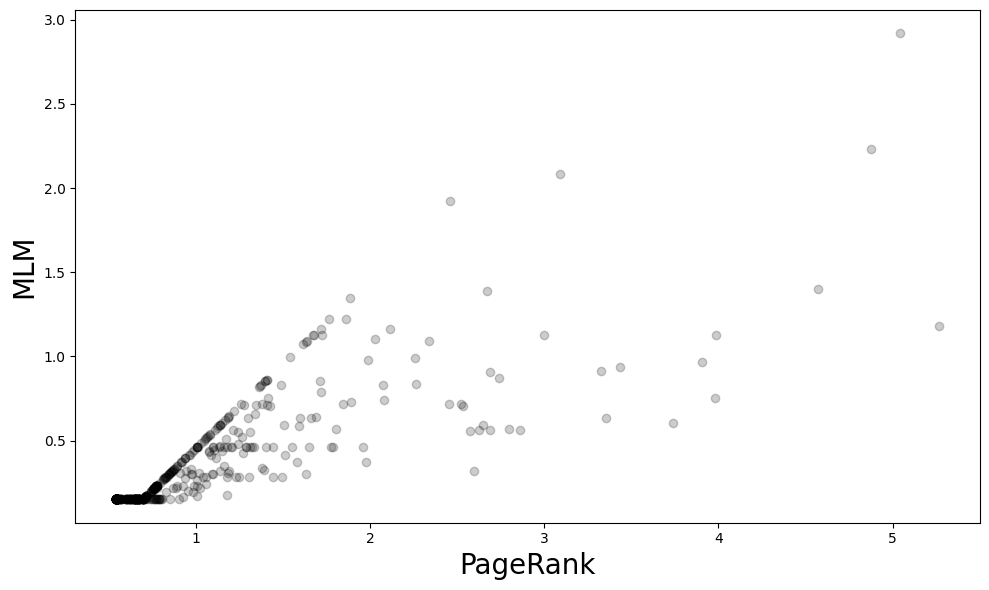

In [7]:
visualise(detector.embeddings.to_numpy(), None, 'img/gpdc_init_normals')

In [8]:
graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
anomalies = detector.update(graph.get_graph())

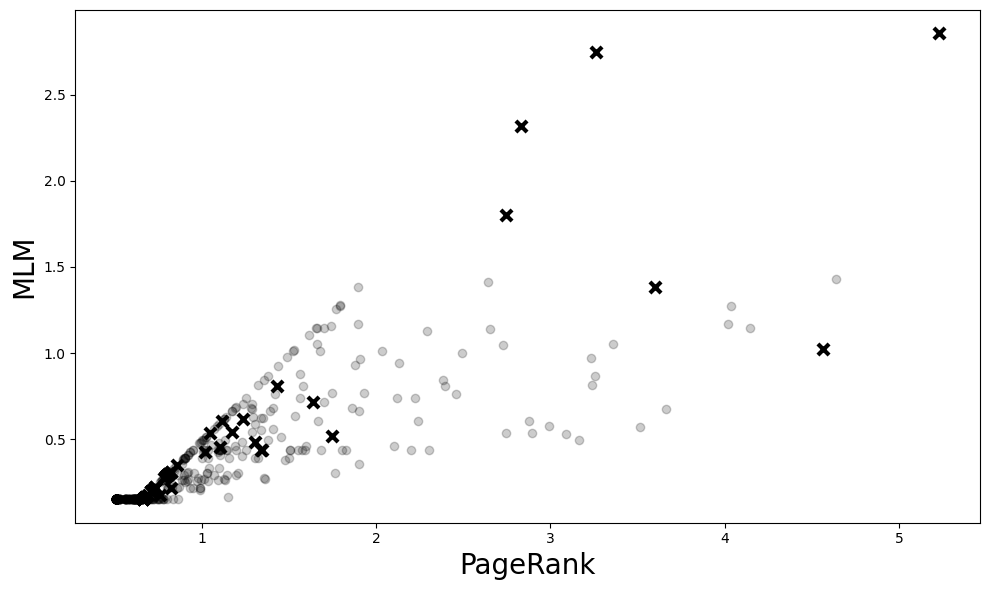

In [9]:
data = detector.embeddings.to_numpy()

visualise(data, anomalies, 'img/gpdc_anomalies1.png')

In [10]:
graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
anomalies = detector.update(graph.get_graph())

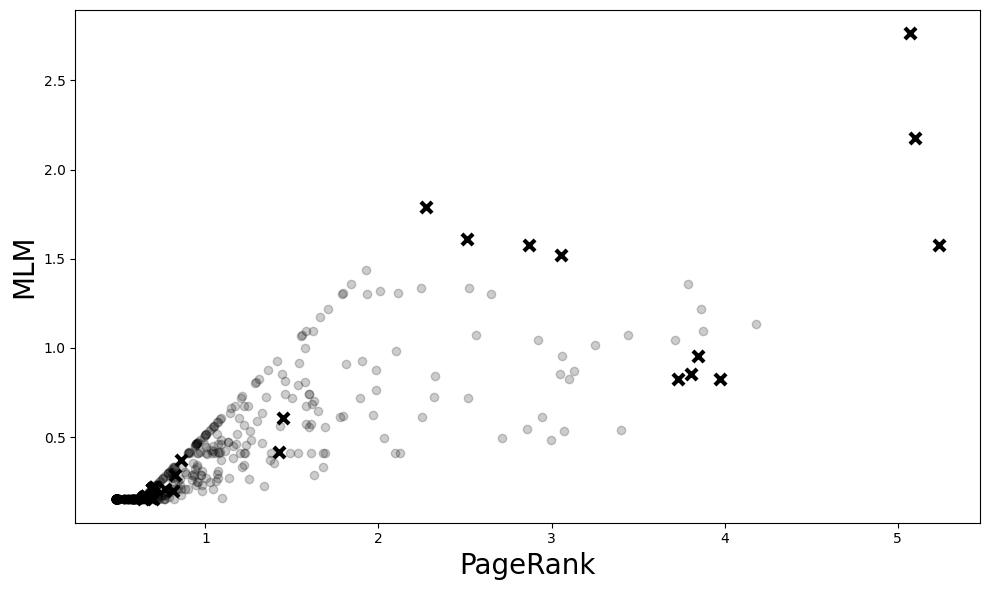

In [11]:
data = detector.embeddings.to_numpy()

visualise(data, anomalies, 'img/gpdc_anomalies2.png')

In [12]:
graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
anomalies = detector.update(graph.get_graph())

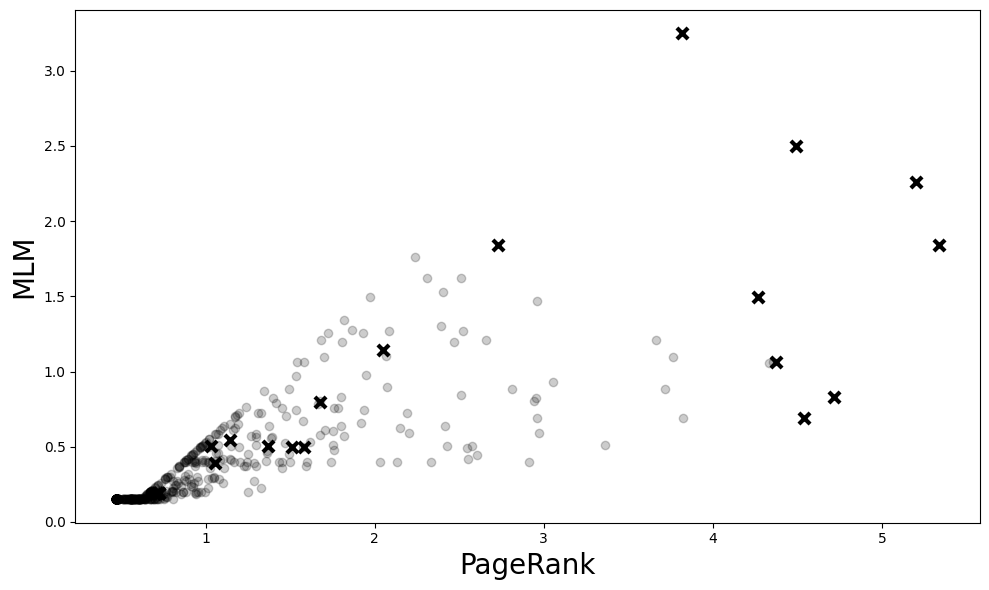

In [13]:
data = detector.embeddings.to_numpy()

visualise(data, anomalies, 'img/gpdc_anomalies3.png')

# Regime change

Let us explore, how GPDC can detect the change of evolution regimе. Initial graph will be obtained after 1000 steps of evolution with parameters $(0.15, 0.8, 0.05)$, then 100 windows with the same parameters and the other 100 windows with parameters $(0.6, 0.1, 0.3)$.

In [25]:
def plot_time_vs_anomalies_ratio(anomalies_ratios: np.ndarray, filename: str | None = None):
    ts = init_steps + np.arange(steps, len(anomalies_ratios) * steps + 1, steps)
    plt.figure(figsize=(12, 7))

    plt.plot(ts, anomalies_ratios, color='black', linewidth=2)
    
    plt.xlabel('Evolution steps', size=20)
    plt.ylabel('Proportion of anomalies', size=20)

    plt.grid(True)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [17]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

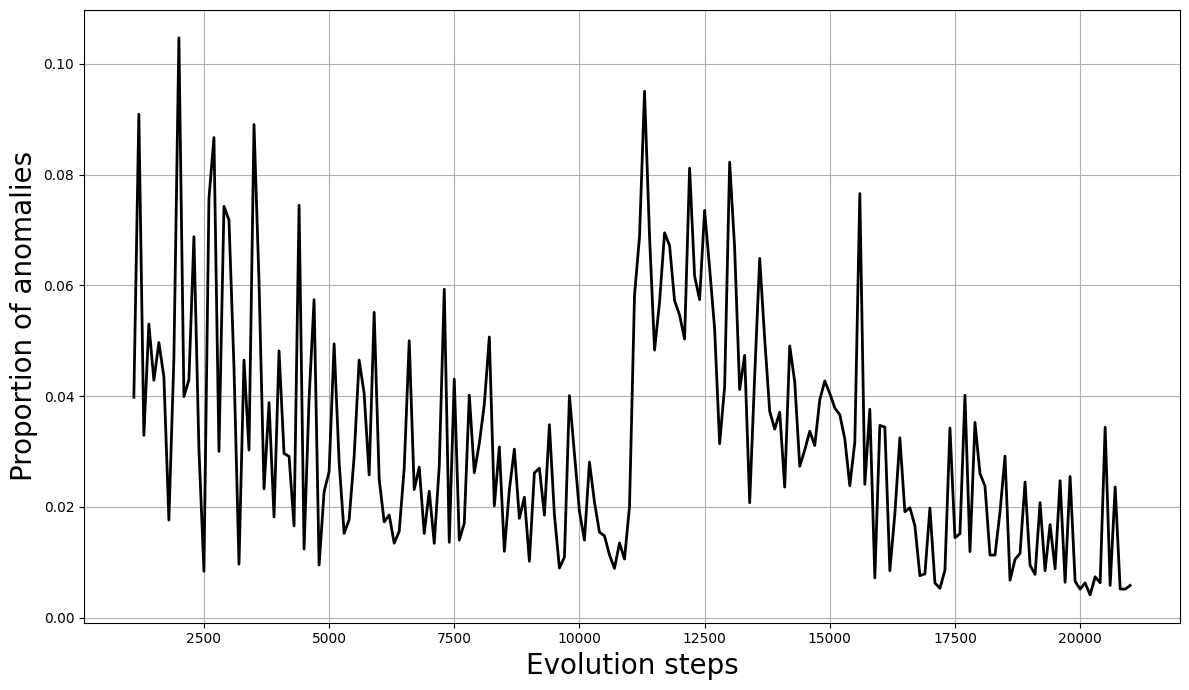

In [18]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change.png')

In [21]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

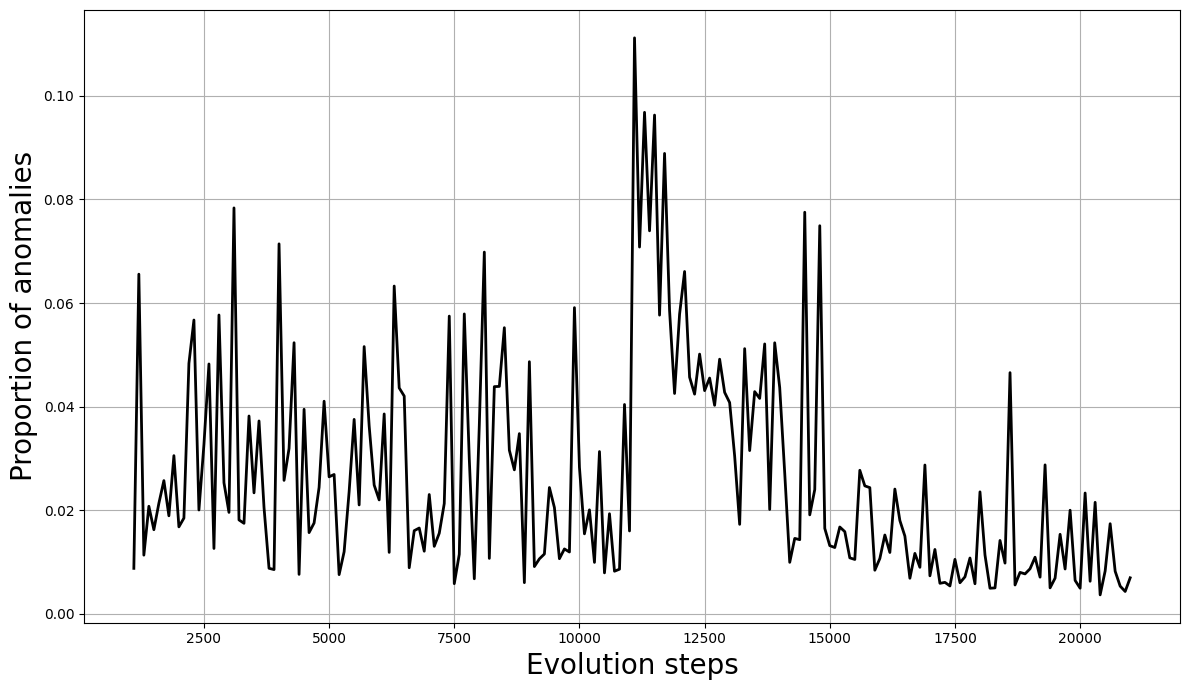

In [22]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_.png')

In [29]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

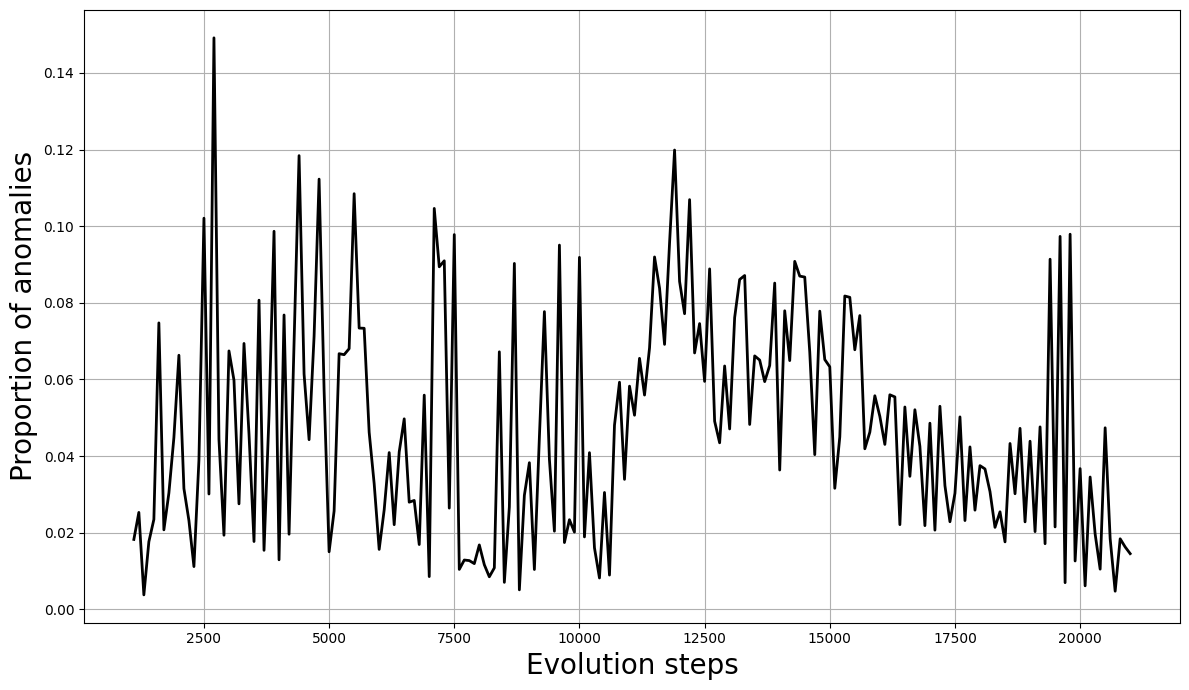

In [30]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_.png')

In [13]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[1], beta=betas[1], gamma=gammas[1], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

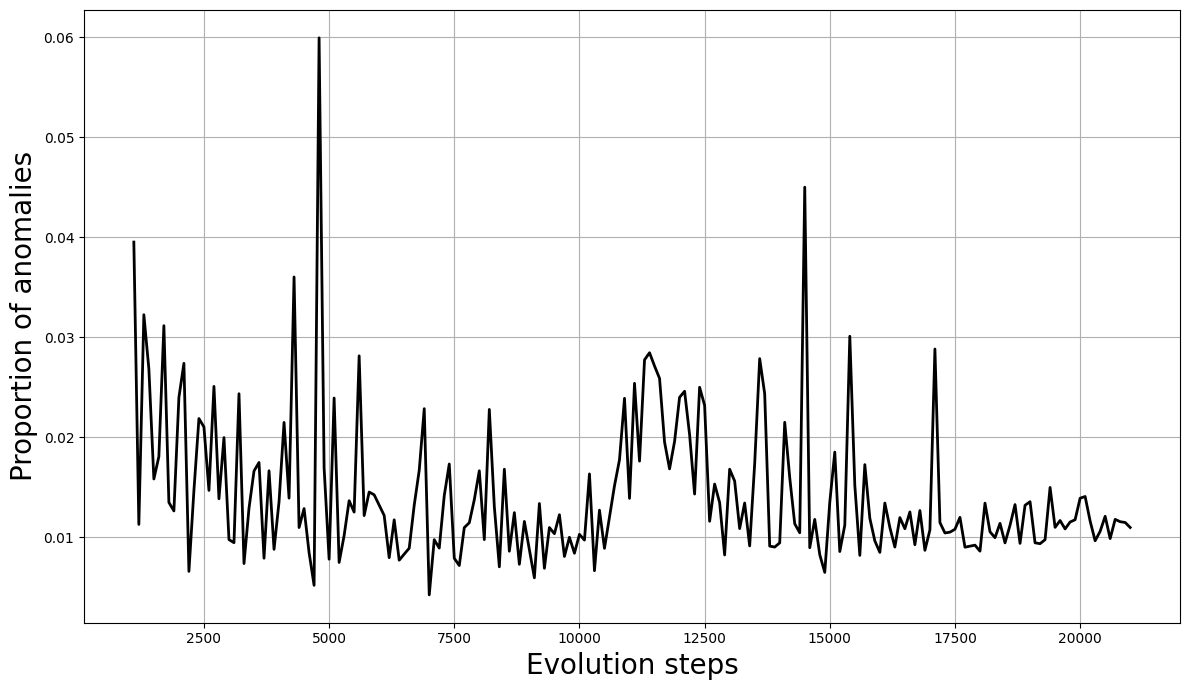

In [14]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_01.png')

In [15]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[1], beta=betas[1], gamma=gammas[1], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

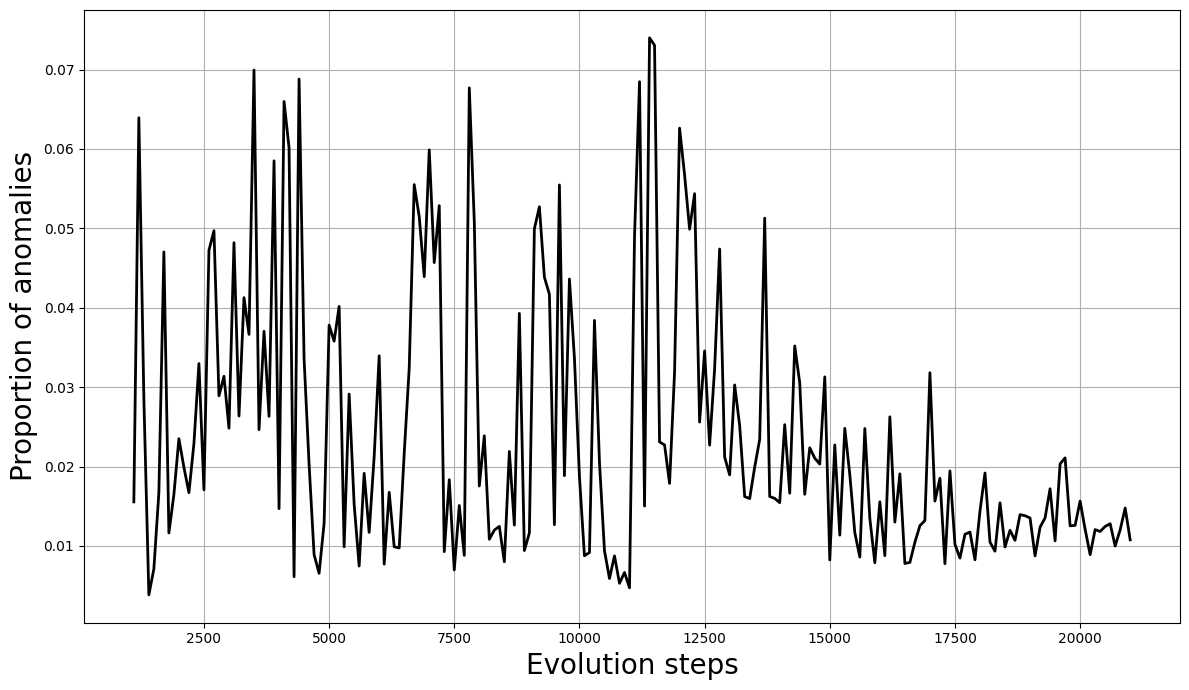

In [16]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_01_.png')

In [17]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[1], beta=betas[1], gamma=gammas[1], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

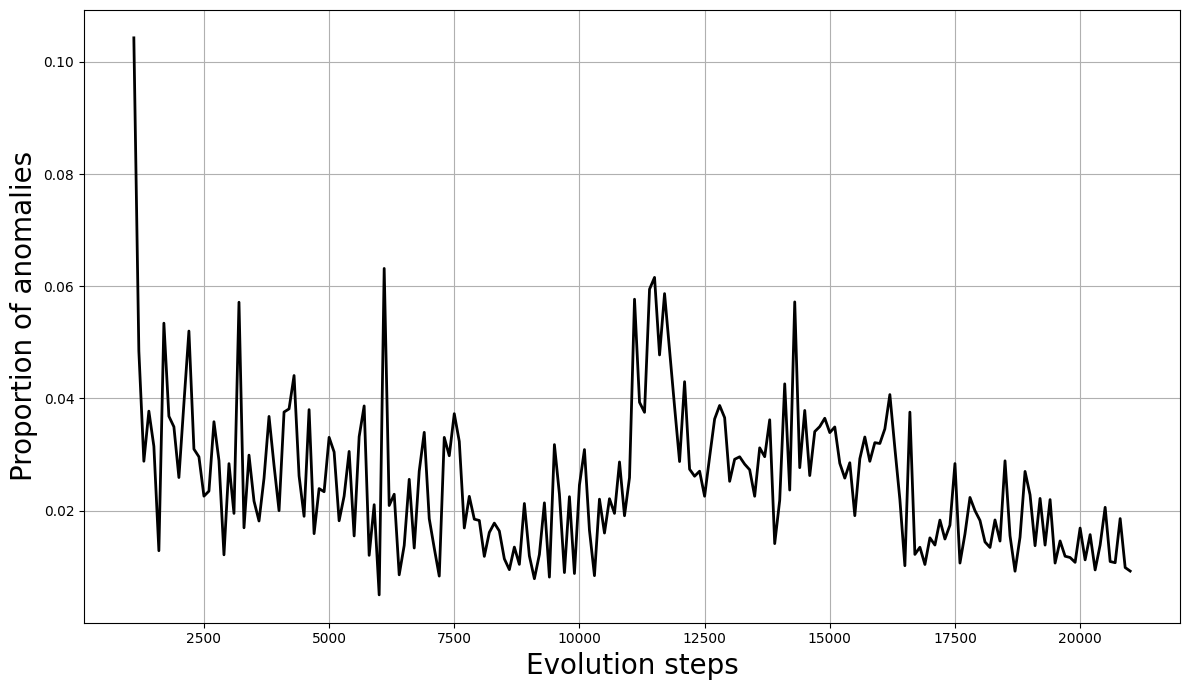

In [18]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_01_.png')

In [19]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

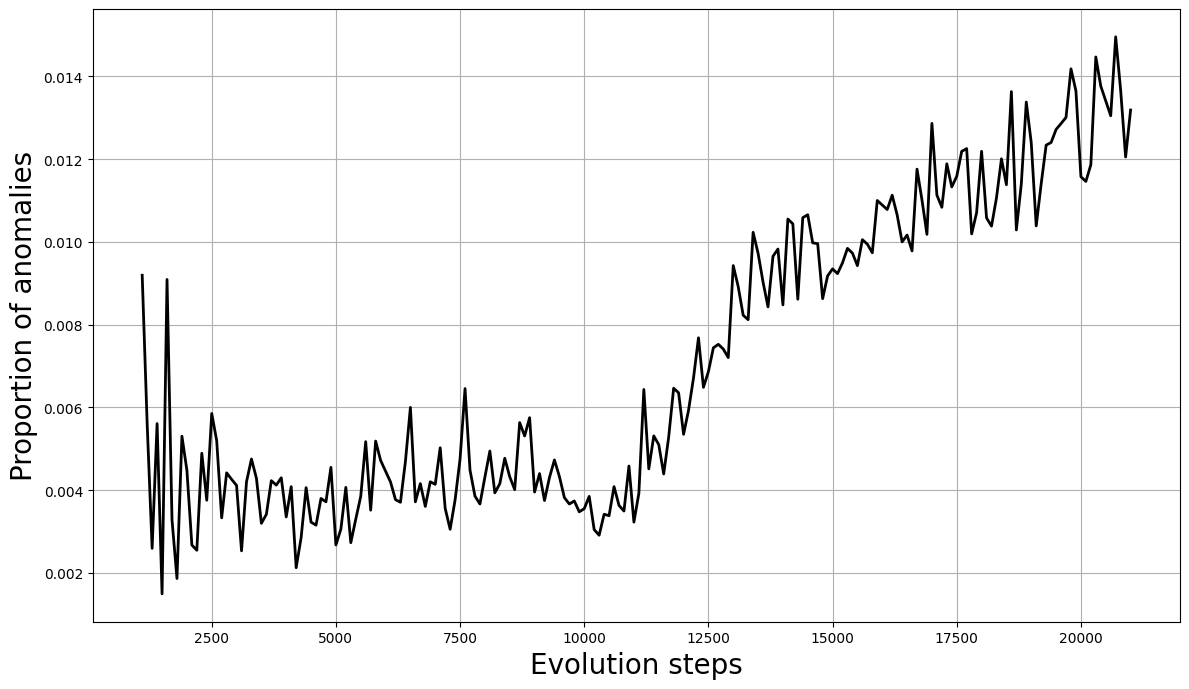

In [20]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_20.png')

In [29]:
init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph(init_graph=init_graph)
graph.grow(steps=init_steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)

detector = GPDCAnomalies(init_graph=graph.get_graph(),
                         embedding_class=embeddings.PageRankMLM)

ratios = []

for j in range(100):
    graph.grow(steps=steps, alpha=alphas[2], beta=betas[2], gamma=gammas[2], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

for j in range(600):
    graph.grow(steps=steps, alpha=alphas[0], beta=betas[0], gamma=gammas[0], delta_in=delta_in, delta_out=delta_out)
    ratios.append(len(detector.update(graph.get_graph())) / len(graph.get_graph()))

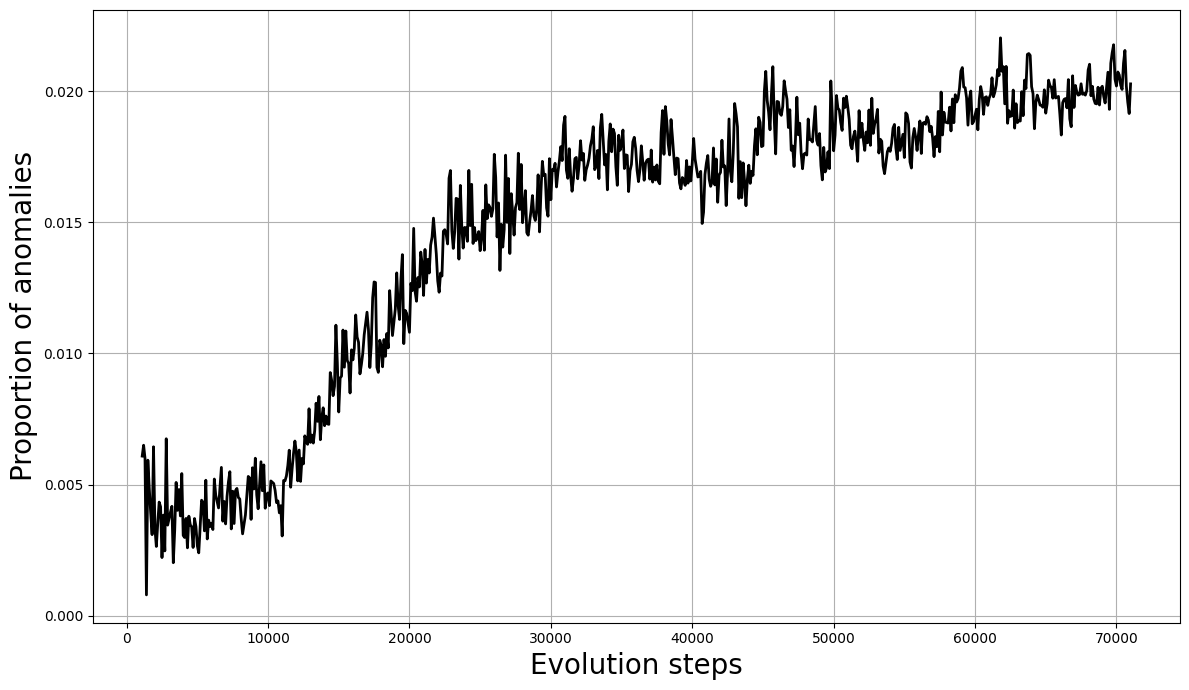

In [30]:
plot_time_vs_anomalies_ratio(ratios, 'img/regime_change_20_.png')